In [185]:
import yaml

In [186]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [187]:
if menu['IDP']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from io import StringIO
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from shapely.geometry import Polygon
    from fiona.crs import from_epsg
    import plotly.graph_objects as go
    import seaborn as sns
    import plotly.express as px
    import csv

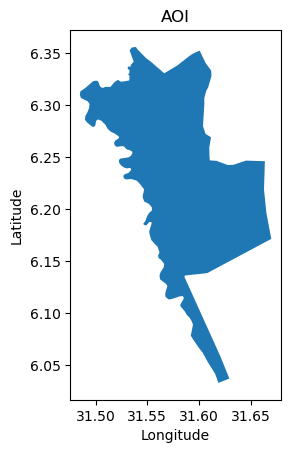

In [188]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("mnt/city-directories/01-user-input/city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans
with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
# Define render folder ---------
render_path = Path('mnt/city-directories/03-render-output')
multi_scan_folder = Path('multi-scan-materials')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [189]:
#import DTM layers
def import_idp_csv(idp_path):
    data = []
    with open(idp_path, 'r') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        for row in csv_reader:
            data.append(row)
    return data

idp_site_path = 'mnt/city-directories/01-user-input/R11 Site Assessment.csv'
idp_site_assessment = import_idp_csv(idp_site_path)
idp_baseline_path ='mnt/city-directories/01-user-input/ R13 Baseline Assessment.csv'
idp_baseline = import_idp_csv(idp_baseline_path)
print("Keys of the first row of idp_baseline:", data[0].keys())

Keys of the first row of idp_baseline: dict_keys(['\ufeffState_INT_PCode', 'state_name', 'County_INT_PCode', 'county_name', 'payam_MT_internal_PCODE', 'payam_name', 'location_ssid', 'village_idp_settlement_name', 'mt_round', 'location_type', 'latitude', 'longitude', 'location_status_name', 'a_idps_present', ' a_idp_hhs_ssd ', ' a_idp_inds_ssd ', ' b_idp_arrival_2014_2018_pre_agrmt_ind ', ' b_idp_arrival_2014_2018_pre_agrmt_state_habitual_residence ', ' b_idp_arrival_2014_2018_pre_agrmt_county_habitual_residence ', ' b_idp_arrival_2018_post_agrmt_2020_ind ', ' b_idp_arrival_2018_post_agrmt_2020_state_habitual_residence ', ' b_idp_arrival_2018_post_agrmt_2020_county_habitual_residence ', ' b_idp_arrival_2021_ind ', ' b_idp_arrival_2021_state_habitual_residence ', ' b_idp_arrival_2021_county_residence ', ' b_idp_arrival_2022_ind ', ' b_idp_arrival_2022_state_habitual_residence ', ' b_idp_arrival_2022_county_residence ', ' b_idp_arrival_unknown_period_ind ', ' b_idp_arrival_unknown_state_h

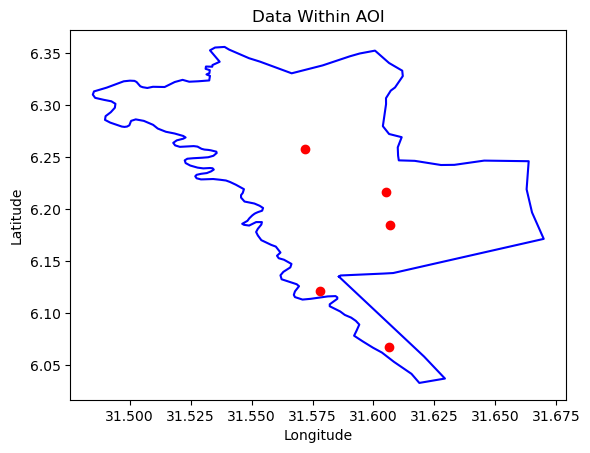

In [190]:

#site assessment csv
def filter_data_within_aoi(data, aoi_polygons):
    filtered_data = []
    for row in data:
        lon = float(row['b10.gps.lon'])
        lat = float(row['b11.gps.lat'])
        point = Point(lon, lat)
        for aoi_polygon in aoi_polygons:
            if aoi_polygon.contains(point):
                filtered_data.append(row)
                break  # Stop checking for other AOI polygons once the point is found within one
    return filtered_data

# Read AOI shapefile and transform to EPSG 4326
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg=4326)
features = aoi_file.geometry.tolist()

# Convert each AOI polygon to a Shapely Polygon object
aoi_polygons = [Polygon(feature.exterior.coords) for feature in features]

# Assuming 'idp_site_assessment' contains your CSV data as a list of dictionaries
data_within_aoi = filter_data_within_aoi(idp_site_assessment, aoi_polygons)

# Plotting the AOI polygons
for feature in features:
    x, y = feature.exterior.xy
    plt.plot(x, y, color='blue')  # Assuming blue color for AOI polygons

# Plotting the data within the AOI
for row in data_within_aoi:
    lon = float(row['b10.gps.lon'])
    lat = float(row['b11.gps.lat'])
    plt.plot(lon, lat, 'ro')  # Assuming red dots for the points within AOI

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Within AOI')
plt.show()


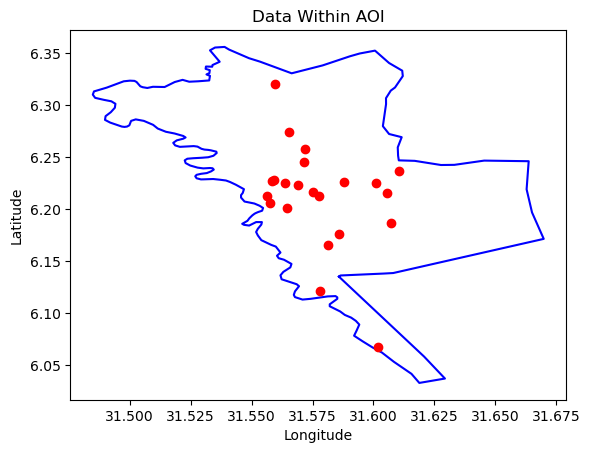

In [191]:
#mobility baseline csv
def base_data_within_aoi(data, aoi_polygons):
    filtered_data = []
    for row in data:
        lon = float(row['longitude'])  # Corrected key for longitude
        lat = float(row['latitude'])   # Corrected key for latitude
        point = Point(lon, lat)
        for aoi_polygon in aoi_polygons:
            if aoi_polygon.contains(point):
                filtered_data.append(row)
                break  # Stop checking for other AOI polygons once the point is found within one
    return filtered_data

# Assuming 'idp_site_assessment' contains your CSV data as a list of dictionaries
base_data_within_aoi = base_data_within_aoi(idp_baseline, aoi_polygons)

# Plotting the AOI polygons
for feature in features:
    x, y = feature.exterior.xy
    plt.plot(x, y, color='blue')  # Assuming blue color for AOI polygons

# Plotting the data within the AOI
for row in base_data_within_aoi:  # Corrected variable name here
    lon = float(row['longitude'])
    lat = float(row['latitude'])
    plt.plot(lon, lat, 'ro')  # Assuming red dots for the points within AOI

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Within AOI')
plt.show()


In [192]:
#sitesassessment
def export_to_csv(data_within_aoi, save_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Export the DataFrame to a CSV file
    df.to_csv(save_path, index=False)  # Set index=False to avoid writing row indices

    return save_path

# Example usage:
save_path = 'mnt/city-directories/03-render-output/data_within_aoi.csv'
csv_path = export_to_csv(data_within_aoi, save_path)
print(f"CSV file saved to: {csv_path}")
print(data_within_aoi[0])

CSV file saved to: mnt/city-directories/03-render-output/data_within_aoi.csv
{'\ufeffa02.mt.round': '11', 'a04.enum.sex': 'Male', 'b01.location.ssid': 'ssid_SS0303_0012', 'b02.location.name': 'Malek', 'b03.nearest.vn': 'Jam Malou', 'b04.state.name': 'Jonglei', 'b05.state.pcode': 'SS03', 'b06.county.name': 'Bor South', 'b07.county.pcode': 'SS0303', 'b08.payam.name': 'Kolnyang', 'b09.payam.pcode': 'SS030305', 'b10.gps.lon': '31.60639954', 'b11.gps.lat': '6.067500114', 'b13.accessibility': 'Accessible by other means of transport', 'b14.settlement.type': 'Planned camp/site', 'b17.idp.disp.reason': 'Communal clashes', 'b18.idp.disp.reason.other.specify': '', 'b19.origin.largest.idp.grp.adm1': 'Central Equatoria', 'b20.origin.largest.idp.grp.adm2': 'Terekeka', 'b21.origin.largest.idp.grp.adm3': 'Gemeiza', 'b21.01.origin.largest.idp.grp.payam.other': '', 'b23.origin.2nd.largest.idp.grp.adm1': '', 'b24.origin.2nd.largest.idp.grp.adm2': '', 'b25.origin.2nd.largest.idp.grp.adm3': '', 'b25.01.ori

In [193]:
#baseline
save_path = 'mnt/city-directories/03-render-output/base_data_within_aoi.csv'
csv_path = export_to_csv(base_data_within_aoi, save_path)
print(f"CSV file saved to: {csv_path}")
print(data_within_aoi[0])


CSV file saved to: mnt/city-directories/03-render-output/base_data_within_aoi.csv
{'\ufeffa02.mt.round': '11', 'a04.enum.sex': 'Male', 'b01.location.ssid': 'ssid_SS0303_0012', 'b02.location.name': 'Malek', 'b03.nearest.vn': 'Jam Malou', 'b04.state.name': 'Jonglei', 'b05.state.pcode': 'SS03', 'b06.county.name': 'Bor South', 'b07.county.pcode': 'SS0303', 'b08.payam.name': 'Kolnyang', 'b09.payam.pcode': 'SS030305', 'b10.gps.lon': '31.60639954', 'b11.gps.lat': '6.067500114', 'b13.accessibility': 'Accessible by other means of transport', 'b14.settlement.type': 'Planned camp/site', 'b17.idp.disp.reason': 'Communal clashes', 'b18.idp.disp.reason.other.specify': '', 'b19.origin.largest.idp.grp.adm1': 'Central Equatoria', 'b20.origin.largest.idp.grp.adm2': 'Terekeka', 'b21.origin.largest.idp.grp.adm3': 'Gemeiza', 'b21.01.origin.largest.idp.grp.payam.other': '', 'b23.origin.2nd.largest.idp.grp.adm1': '', 'b24.origin.2nd.largest.idp.grp.adm2': '', 'b25.origin.2nd.largest.idp.grp.adm3': '', 'b25.0

In [194]:
#column search function
def does_column_exist(data_within_aoi, column_name):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Check if the column exists in the DataFrame
    return column_name in df.columns

# Example usage:
column_name = ' c02.idp.ind '
if does_column_exist(data_within_aoi, column_name):
    print(f"The column '{column_name}' exists in the DataFrame.")
else:
    print(f"The column '{column_name}' does not exist in the DataFrame.")

The column ' c02.idp.ind ' exists in the DataFrame.


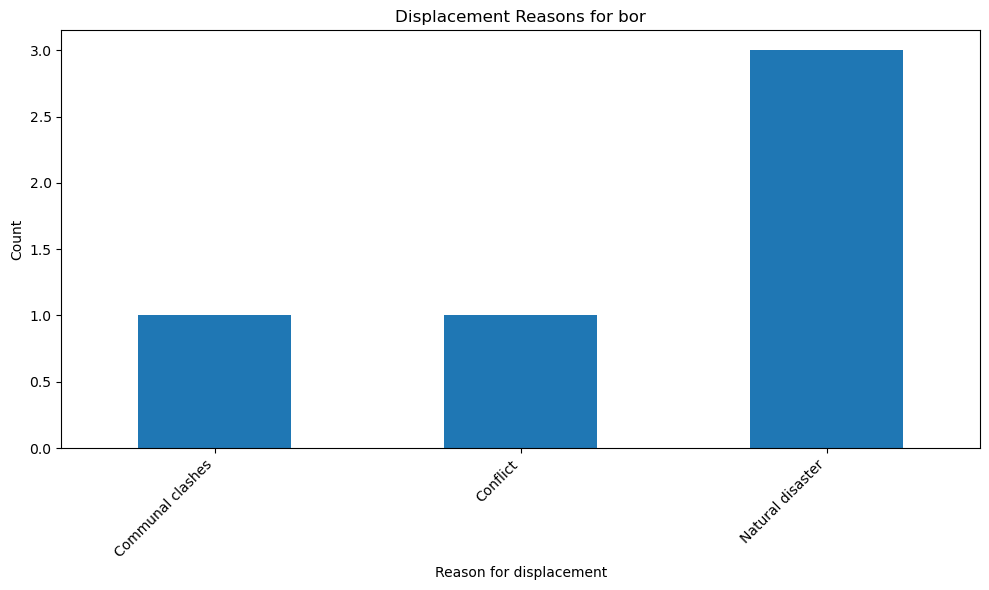

Chart saved to: mnt/city-directories/03-render-output/idp_settlementbyhh.png


In [201]:
#displacement reason
def get_displacement_reason(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Create a pivot table with counts of 'b17.idp.disp.reason' for each 'b02.location.name'
    pivot_table = pd.pivot_table(df, index='b02.location.name', columns='b17.idp.disp.reason', aggfunc='size', fill_value=0)

    # Summing the counts of each category
    pivot_table = pivot_table.apply(lambda x: x.sum(), axis=0)

    # Plotting the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')
    plt.xlabel('Reason for displacement')
    plt.ylabel('Count')
    plt.title(f'Displacement Reasons for {city}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Create the 'render_path' directory if it doesn't exist
    if not os.path.exists(render_path):
        os.makedirs(render_path)

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'displacement_reason_chart.png')
    plt.savefig(save_path)
    plt.show()

    return save_path

# Example usage:
displacement_reason_path = get_displacement_reason(data_within_aoi, render_path)
print(f"Chart saved to: {chart_path}")


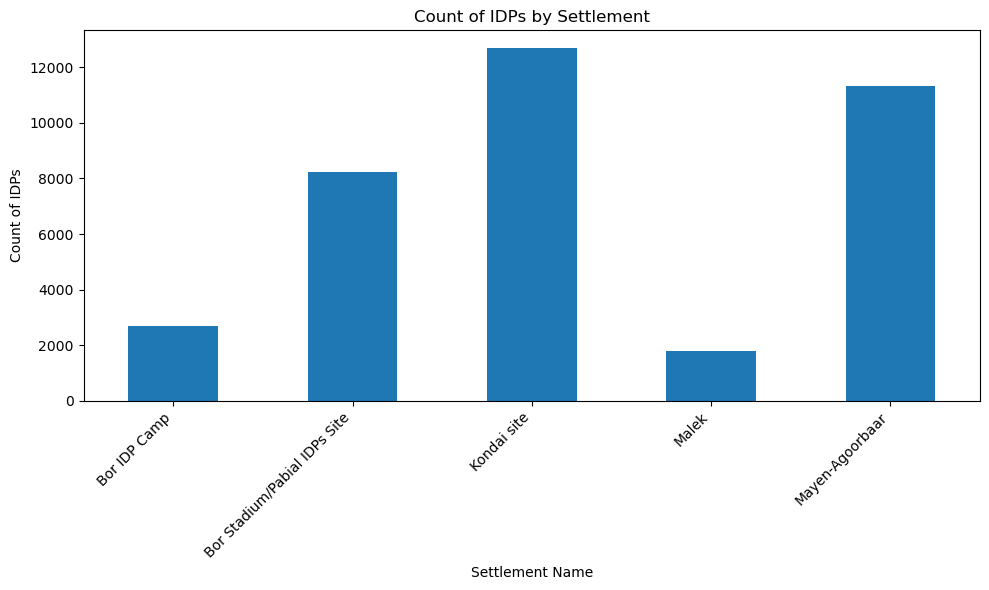

Chart saved to: mnt/city-directories/03-render-output/idp_individuals.png


In [200]:
#total individuals per settlement

def individual_chart(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Clean and convert the 'c02.idp.ind' column
    df['idp.ind'] = df[' c02.idp.ind '].str.replace(',', '').str.strip().astype(float)

    # Drop the original column with spaces
    df.drop(columns=[' c02.idp.ind '], inplace=True)

    # Group by 'b02.location.name' and sum the counts of 'idp.ind'
    grouped_data = df.groupby('b02.location.name')['idp.ind'].sum()

    # Plot the grouped data as a bar chart
    plt.figure(figsize=(10, 6))
    grouped_data.plot(kind='bar')
    plt.xlabel('Settlement Name')
    plt.ylabel('Count of IDPs')
    plt.title('Count of IDPs by Settlement')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    
    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'idp_individuals.png')
    plt.savefig(save_path)
    
    # Show the plot
    plt.show()

    return save_path

# Example usage:
ind_count_path = individual_chart(data_within_aoi, render_path)
print(f"Chart saved to: {ind_count_path}")

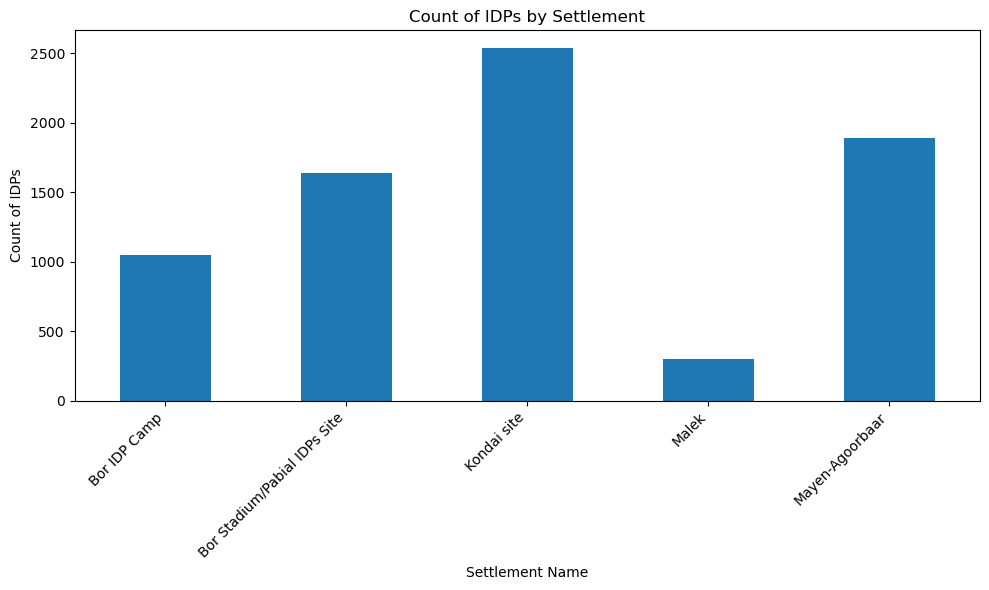

In [199]:
#total households
def household_chart(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Clean and convert the 'c02.idp.ind' column
    df['idp.hh'] = df[' c01.idp.hh '].str.replace(',', '').str.strip().astype(float)

    # Drop the original column with spaces
    df.drop(columns=[' c01.idp.hh '], inplace=True)

    # Group by 'b02.location.name' and sum the counts of 'idp.ind'
    grouped_data = df.groupby('b02.location.name')['idp.hh'].sum()

    # Plot the grouped data as a bar chart
    plt.figure(figsize=(10, 6))
    grouped_data.plot(kind='bar')
    plt.xlabel('Settlement Name')
    plt.ylabel('Count of IDPs')
    plt.title('Count of IDPs by Settlement')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    
    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_folder, 'idp_hh.png')
    plt.savefig(save_path)
    
    # Show the plot
    plt.show()

    return save_path

# Example usage:
hh_count_path = household_chart(data_within_aoi, render_path)

In [198]:
#settlement type
def settlement_type_chart(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Clean and convert the 'c01.idp.hh' column
    df['idp.hh'] = df[' c01.idp.hh '].str.replace(',', '').str.strip().astype(float)

    # Drop the original column with spaces
    df.drop(columns=[' c01.idp.hh '], inplace=True)

    # Group by 'b14.settlement.type' and count the number of 'idp.hh' in each group
    pivot_table = pd.pivot_table(df, values='idp.hh', index='b14.settlement.type', aggfunc='count')

    # Plot the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')
    plt.xlabel('Settlement Type')
    plt.ylabel('Count of IDP Households')
    plt.title('Count of IDP Households by Settlement Type')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()

    
    
    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_folder, 'idp_typebysettlement.png')
    plt.savefig(save_path)
    plt.close()
    # Show the plot
    plt.show()

    return save_path

# Example usage:
settlement_chart_path = settlement_type_chart(data_within_aoi,render_path)


<Figure size 1000x600 with 0 Axes>

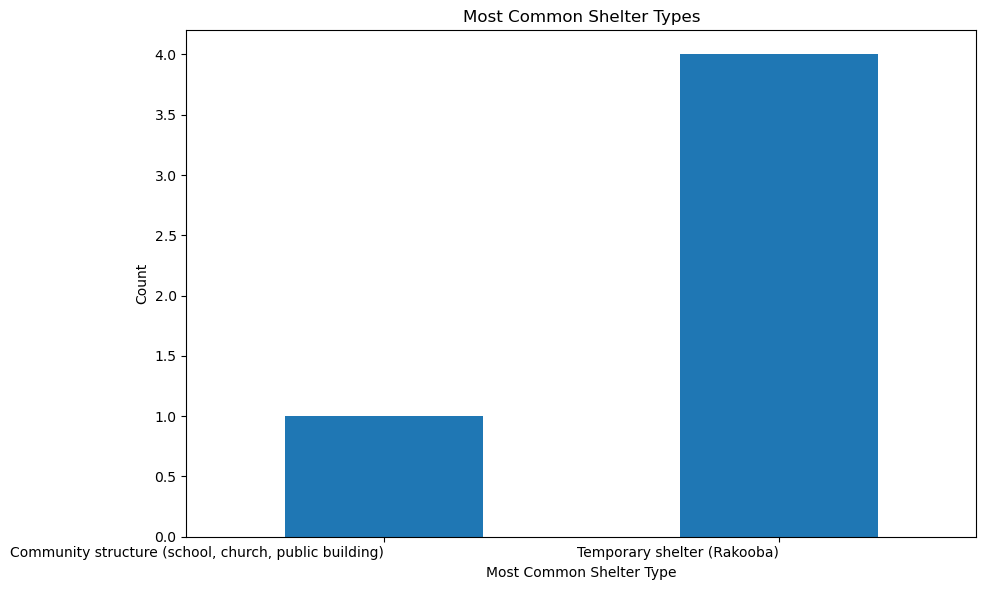

Chart saved to: mnt/city-directories/03-render-output/shelter_type_chart.png


In [205]:
#shelter type
def get_shelter_type(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Create a pivot table with counts of 'f06.shelter.type.most.common' for each 'b02.location.name'
    pivot_table = pd.pivot_table(df, index='b02.location.name', columns='f06.shelter.type.most.common', aggfunc='size', fill_value=0)

    # Summing the counts of each category
    pivot_table = pivot_table.apply(lambda x: x.sum(), axis=0)

    # Plotting the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')  # Customizing color to skyblue
    plt.xlabel('Most Common Shelter Type')
    plt.ylabel('Count')
    plt.title('Most Common Shelter Types')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()

    # Create the 'render_path' directory if it doesn't exist
    if not os.path.exists(render_path):
        os.makedirs(render_path)

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'shelter_type_chart.png')
    plt.savefig(save_path)
    plt.show()

    return save_path

# Example usage:
shelter_type_path = get_shelter_type(data_within_aoi, render_path)
print(f"Chart saved to: {shelter_type_path}")


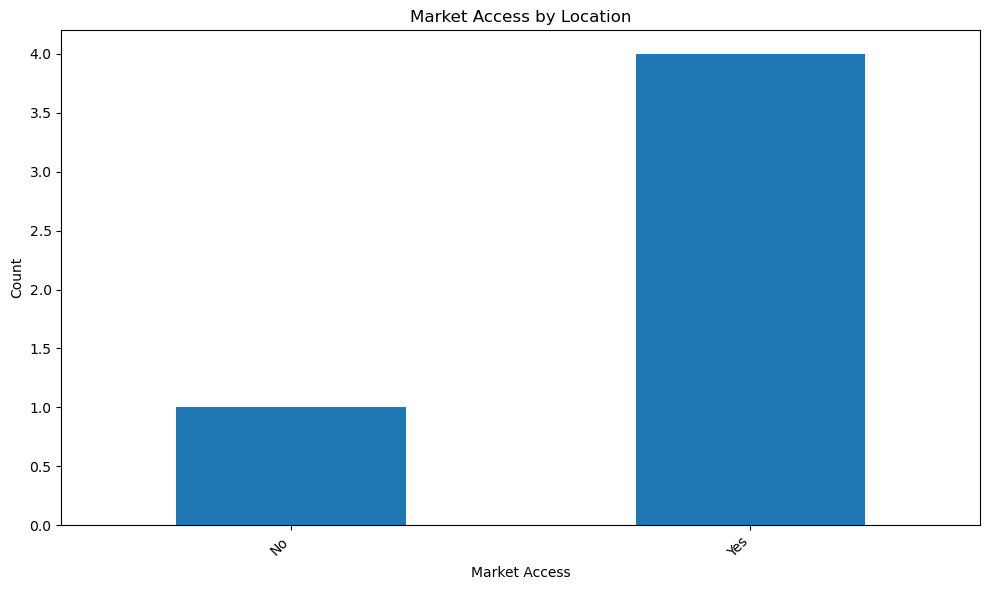

Chart saved to: mnt/city-directories/03-render-output/market_access_chart.png


In [207]:
#market access

def get_market_access(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Create a pivot table with counts of 'f14.nfi.market.access' for each 'b02.location.name'
    pivot_table = pd.pivot_table(df, index='b02.location.name', columns='f14.nfi.market.access', aggfunc='size', fill_value=0)

    # Summing the counts of each category
    pivot_table = pivot_table.apply(lambda x: x.sum(), axis=0)

    # Plotting the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')  # Customizing color to lightgreen
    plt.xlabel('Market Access')
    plt.ylabel('Count')
    plt.title('Market Access by Location')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Create the 'render_path' directory if it doesn't exist
    if not os.path.exists(render_path):
        os.makedirs(render_path)

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'market_access_chart.png')
    plt.savefig(save_path)
    plt.show()

    return save_path

# Example usage:
market_access_path = get_market_access(data_within_aoi, render_path)
print(f"Chart saved to: {market_access_path}")


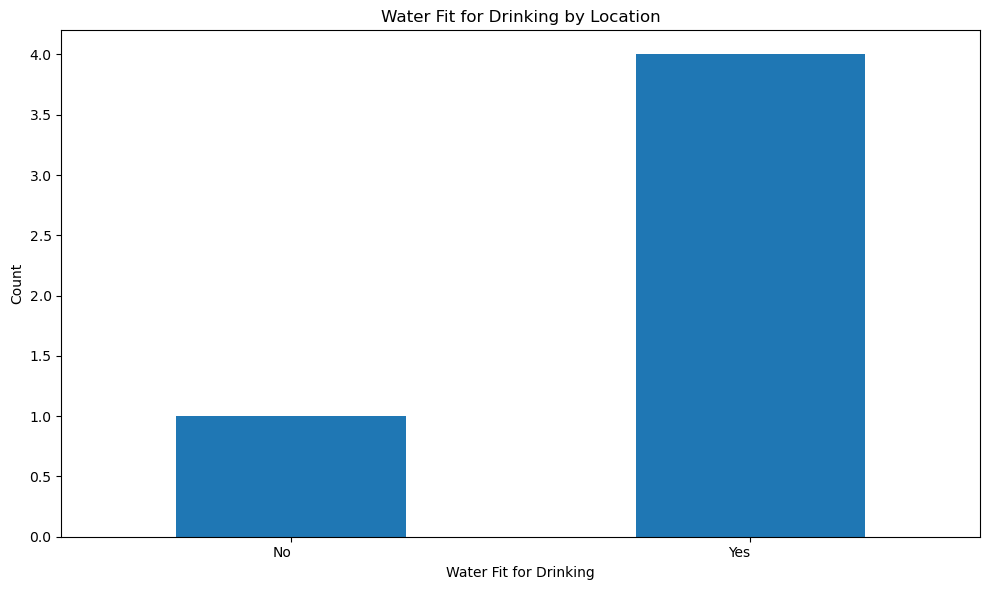

Chart saved to: mnt/city-directories/03-render-output/water_access_chart.png


In [210]:
#water access
def get_water_access(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Create a pivot table with counts of 'g09.water.fit.for.drinking' for each 'b02.location.name'
    pivot_table = pd.pivot_table(df, index='b02.location.name', columns='g09.water.fit.for.drinking', aggfunc='size', fill_value=0)

    # Summing the counts of each category
    pivot_table = pivot_table.apply(lambda x: x.sum(), axis=0)

    # Plotting the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')  # Customizing color to lightcoral
    plt.xlabel('Water Fit for Drinking')
    plt.ylabel('Count')
    plt.title('Water Fit for Drinking by Location')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()

    # Create the 'render_path' directory if it doesn't exist
    if not os.path.exists(render_path):
        os.makedirs(render_path)

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'water_access_chart.png')
    plt.savefig(save_path)
    plt.show()

    return save_path

# Example usage:
water_access_path = get_water_access(data_within_aoi, render_path)
print(f"Chart saved to: {water_access_path}")


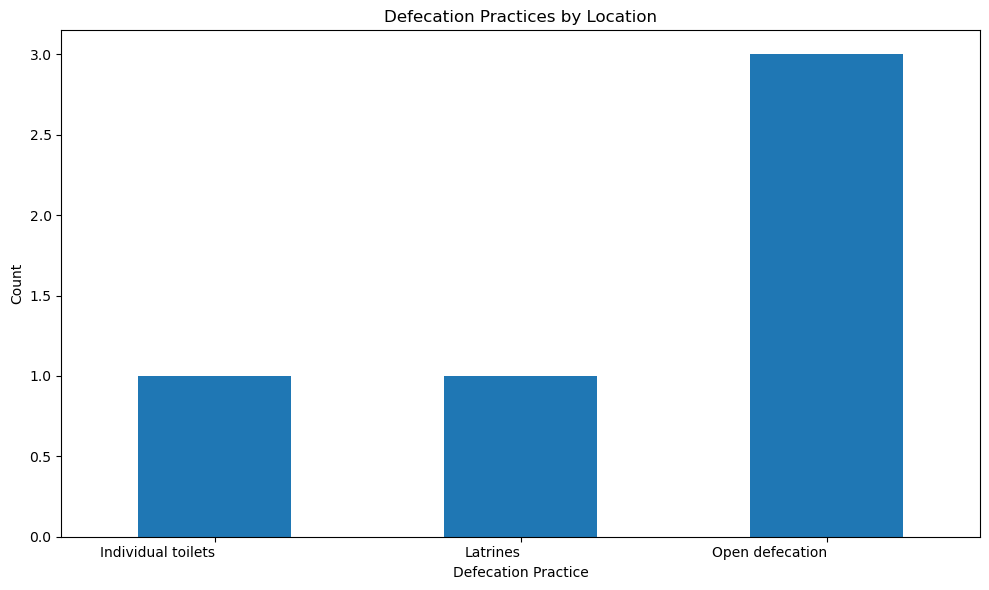

Chart saved to: mnt/city-directories/03-render-output/sanitation_access_chart.png


In [213]:
#sanitation


def get_san_access(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Create a pivot table with counts of 'g16.defecation' for each 'b02.location.name'
    pivot_table = pd.pivot_table(df, index='b02.location.name', columns='g16.defecation', aggfunc='size', fill_value=0)

    # Summing the counts of each category
    pivot_table = pivot_table.apply(lambda x: x.sum(), axis=0)

    # Plotting the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')  # Customizing color to lightblue
    plt.xlabel('Defecation Practice')
    plt.ylabel('Count')
    plt.title('Defecation Practices by Location')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()

    # Create the 'render_path' directory if it doesn't exist
    if not os.path.exists(render_path):
        os.makedirs(render_path)

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'sanitation_access_chart.png')
    plt.savefig(save_path)
    plt.show()

    return save_path

# Example usage:
san_access_path = get_san_access(data_within_aoi, render_path)
print(f"Chart saved to: {san_access_path}")


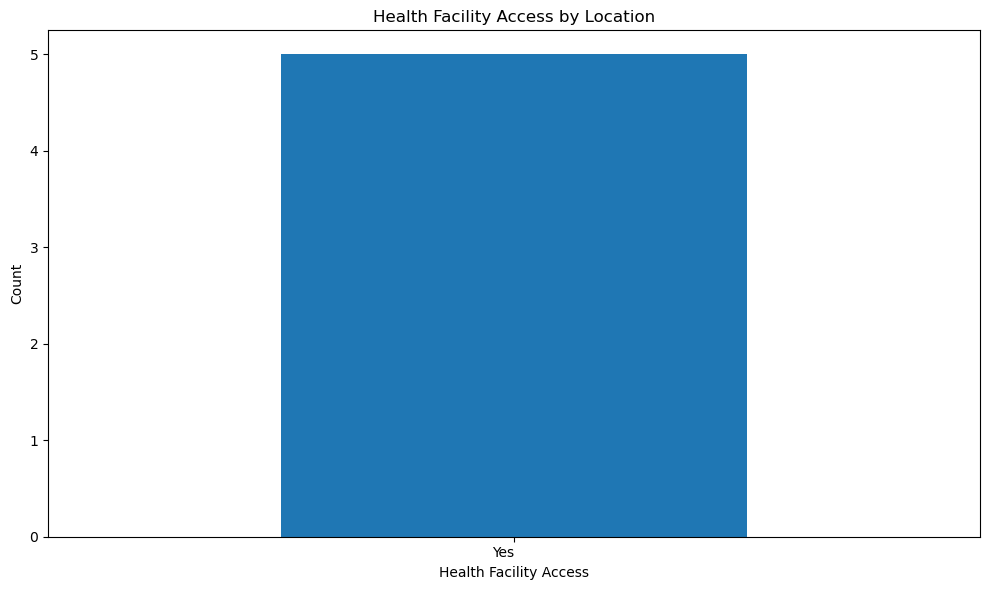

Chart saved to: mnt/city-directories/03-render-output/health_access_chart.png


In [216]:
#health access

def get_health_access(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Create a pivot table with counts of 'i04.health.facility.access' for each 'b02.location.name'
    pivot_table = pd.pivot_table(df, index='b02.location.name', columns='i04.health.facility.access', aggfunc='size', fill_value=0)

    # Summing the counts of each category
    pivot_table = pivot_table.apply(lambda x: x.sum(), axis=0)

    # Plotting the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')  # Customizing color to lightyellow
    plt.xlabel('Health Facility Access')
    plt.ylabel('Count')
    plt.title('Health Facility Access by Location')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()

    # Create the 'render_path' directory if it doesn't exist
    if not os.path.exists(render_path):
        os.makedirs(render_path)

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'health_access_chart.png')
    plt.savefig(save_path)
    plt.show()

    return save_path

# Example usage:
health_access_path = get_health_access(data_within_aoi, render_path)
print(f"Chart saved to: {health_access_path}")


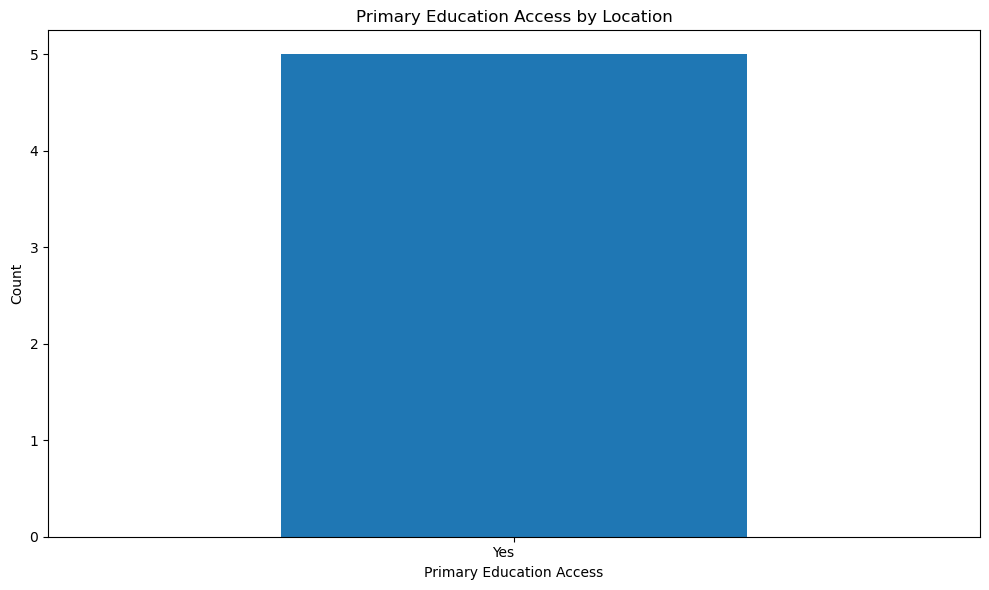

Chart saved to: mnt/city-directories/03-render-output/edu_access_chart.png


In [218]:
#education

def get_edu_access(data_within_aoi, render_path):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(data_within_aoi)

    # Create a pivot table with counts of 'j01.primary.edu.access' for each 'b02.location.name'
    pivot_table = pd.pivot_table(df, index='b02.location.name', columns='j01.primary.edu.access', aggfunc='size', fill_value=0)

    # Summing the counts of each category
    pivot_table = pivot_table.apply(lambda x: x.sum(), axis=0)

    # Plotting the pivot table as a bar chart
    plt.figure(figsize=(10, 6))
    pivot_table.plot(kind='bar')  # Customizing color to lightgreen
    plt.xlabel('Primary Education Access')
    plt.ylabel('Count')
    plt.title('Primary Education Access by Location')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()

    # Create the 'render_path' directory if it doesn't exist
    if not os.path.exists(render_path):
        os.makedirs(render_path)

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'edu_access_chart.png')
    plt.savefig(save_path)
    plt.show()

    return save_path

# Example usage:
edu_access_path = get_edu_access(data_within_aoi, render_path)
print(f"Chart saved to: {edu_access_path}")


<Figure size 1200x600 with 0 Axes>

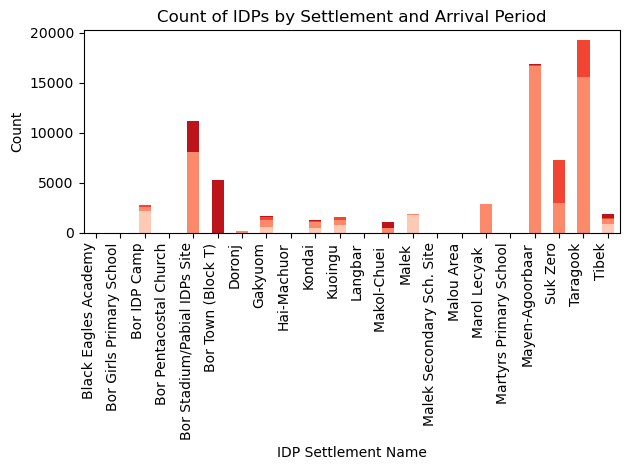

In [184]:
#year of arrival
def create_stacked_bar_chart(base_data_within_aoi, render_path, columns):
    # Convert data_within_aoi to a DataFrame
    df = pd.DataFrame(base_data_within_aoi)
    # Convert specified columns to numeric
    df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with NaN values
    df.dropna(subset=columns, inplace=True)

    # Group by 'village_idp_settlement_name' and calculate the sum of specified columns
    pivot_table = df.groupby('village_idp_settlement_name')[columns].sum()

    # Define colors for each column
    num_years = len(columns)
    colors = plt.cm.Reds(np.linspace(0.2, 0.8, num_years))  # Adjust shades of red here

    # Plot the pivot table as a stacked bar chart
    plt.figure(figsize=(12, 6))
    pivot_table.plot(kind='bar', stacked=True, color=colors, legend = False)
    plt.xlabel('IDP Settlement Name')
    plt.ylabel('Count')
    plt.title('Count of IDPs by Settlement and Arrival Period')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()

    # Save the plot to the 'render_path' directory
    save_path = os.path.join(render_path, 'idp_stacked_bar_chart.png')
    plt.savefig(save_path)  # Save the plot before displaying it
    plt.show()  # Display the plot

    return save_path

# Specify the columns for the stacked bar chart
columns = [' b_idp_arrival_2014_2018_pre_agrmt_ind ', ' b_idp_arrival_2018_post_agrmt_2020_ind ', 
           ' b_idp_arrival_2021_ind ', ' b_idp_arrival_2022_ind ']

# Example usage:
stacked_bar_chart_path = create_stacked_bar_chart(base_data_within_aoi_result, render_path, columns)
